In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import itertools
import powerlaw

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2025-09-20.h5'

minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 10 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength, smoothingWindow, maximumTimeSkip,
                                            excludeOutliers, excludeShortSegments, excludeObjects,
                                            padding, inversePadding, debug=True)

Removing trajectories near walls: 100%|███████| 494/494 [00:55<00:00,  8.89it/s]

Loaded 1091 segments!


As is emphasized in many other parts of this project, discretizing a continuous trajectory is a very subjective process, so you need to be very careful in choosing your parameters. As such, here we survey a range of parameters, principally the colinearity threshold (`c`) and the velocity threshold (`velocityThreshold`).

In [63]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
cArr = np.linspace(0.2, 0.7, 5)
# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = np.linspace(1, 10, 5) # mm/s

# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 4 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    discreteDataArr.append([])
    discreteStepSizeArr.append([])
    waitTimeArr.append([])
    runTimeArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        discreteDataArr[-1].append(discreteTraj)
        
        discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        waitTimeArr[-1].append(waitingTimes)
        runTimeArr[-1].append(runTimes)


100%|███████████████████████████████████████| 1091/1091 [00:14<00:00, 73.07it/s]


## Run time distribution

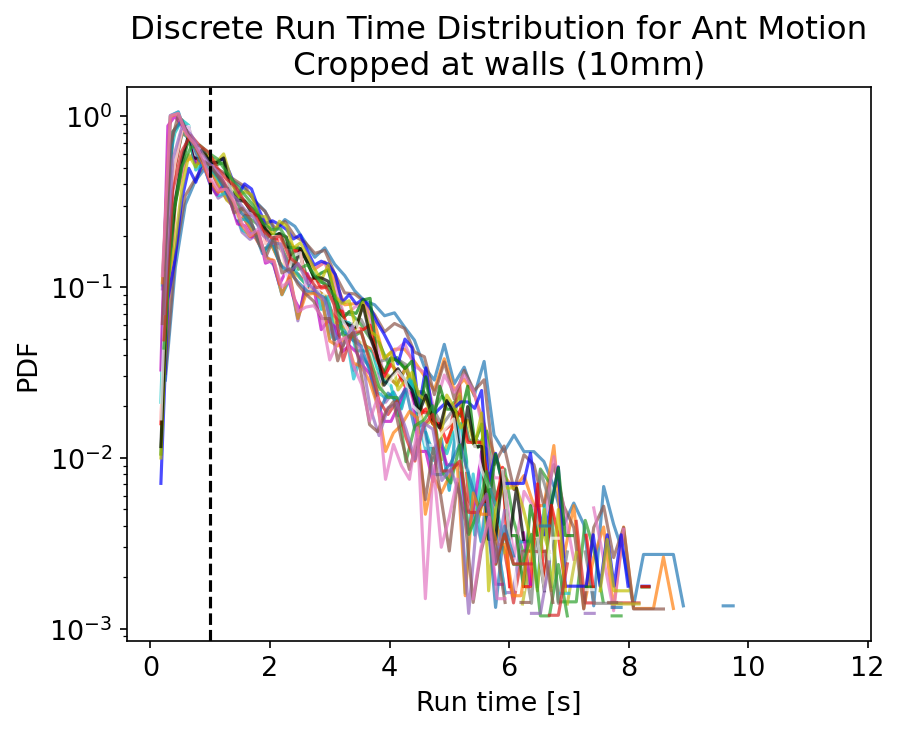

In [73]:
# Minimum time; just a reasonable (empirical) value
xMin = 1 # [s]
# Maximum time
xMax = None

colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

fig, ax = plt.subplots()

for i in range(len(runTimeArr)):
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax, color=colors[i % len(colors)], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.3}$', alpha=0.7)


plt.axvline(xMin, linestyle='--', c='black')
#plt.axvline(xMax, linestyle='--', c='black')

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run time [s]')
#plt.legend(fontsize=10)
#plt.title('Discrete Run Time Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Time Distribution for Ant Motion\nCropped at walls (10mm)')
pltsaveall('12_DiscreteRunTime_Cropped')
plt.show()

## Fitting run time

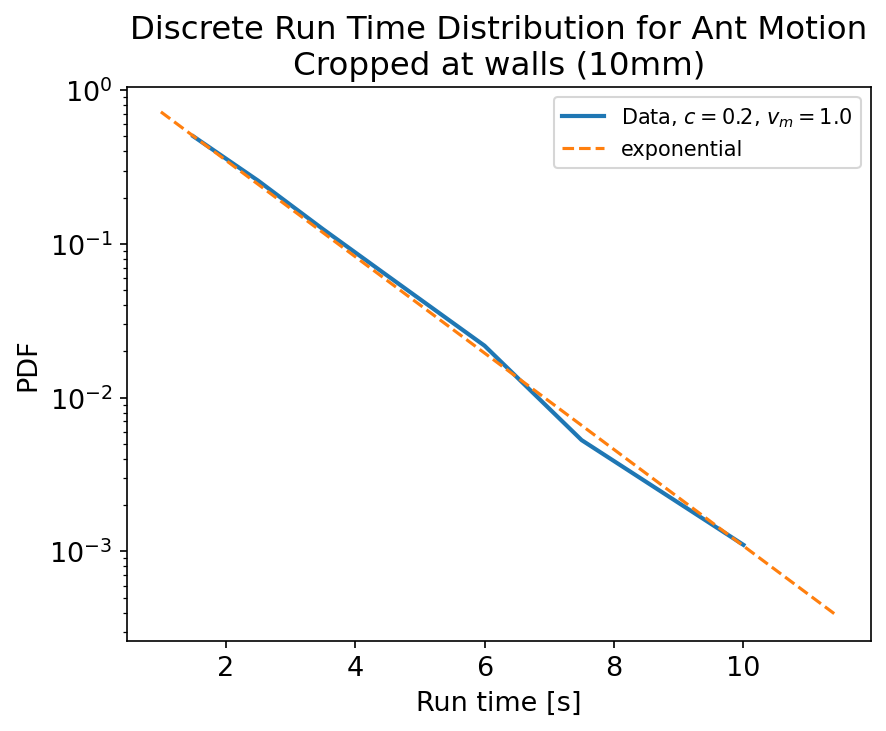

In [81]:
colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

fig, ax = plt.subplots()

for i in [0]:#range(len(discreteStepSizeArr)):
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    fit = powerlaw.Fit(runTimes, xmin=xMin, xmax=xMax)
    
    fit.plot_pdf(ax=ax, color=colors[i % len(colors)], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.3}$', linewidth=2)
    fit.exponential.plot_pdf(ax=ax, linestyle='--', color=colors[1], label='exponential')

plt.yscale('log')
plt.xscale('linear')
plt.ylabel('PDF')
#plt.xlim([None, 1100])
plt.xlabel('Run time [s]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Time Distribution for Ant Motion\nCropped at walls (10mm)')
pltsaveall('12_DiscreteRunTime_TestFit')
plt.show()

In [76]:
lambdaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(discreteStepSizeArr)):
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    fit = powerlaw.Fit(runTimes, xmin=xMin, xmax=xMax)

    lambdaArr[i] = fit.exponential.Lambda

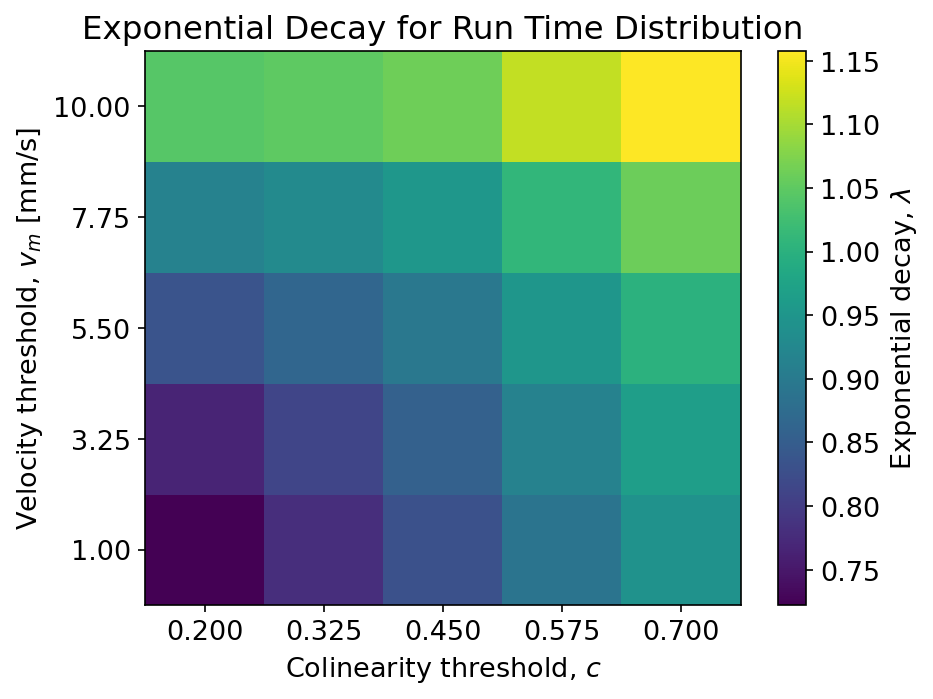

In [77]:
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

lambdaMatrix = lambdaArr.reshape((len(uniqueCArr), len(uniqueVArr)))

plt.pcolor(uniqueCArr, uniqueVArr, lambdaMatrix)
plt.colorbar(label='Exponential decay, $\\lambda$')
plt.xticks(uniqueCArr)
plt.yticks(uniqueVArr)
plt.xlabel('Colinearity threshold, $c$')
plt.ylabel('Velocity threshold, $v_m$ [mm/s]')
plt.title('Exponential Decay for Run Time Distribution')
#pltsaveall('11_DiscreteWaitTime_FitParameters')
plt.show()

In [79]:
chosenDistribution = 'exponential'
alternativeDistributions = ['truncated_power_law', 'lognormal', 'power_law', 'stretched_exponential']
comparisonMatrix = np.zeros((len(discreteStepSizeArr), len(alternativeDistributions), 2))

for i in range(len(discreteStepSizeArr)):
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    fit = powerlaw.Fit(runTimes, xmin=xMin, xmax=xMax)
    
    for j in range(len(alternativeDistributions)):
        R, p = fit.distribution_compare(chosenDistribution, alternativeDistributions[j], normalized_ratio=True)
        comparisonMatrix[i,j] = R, p

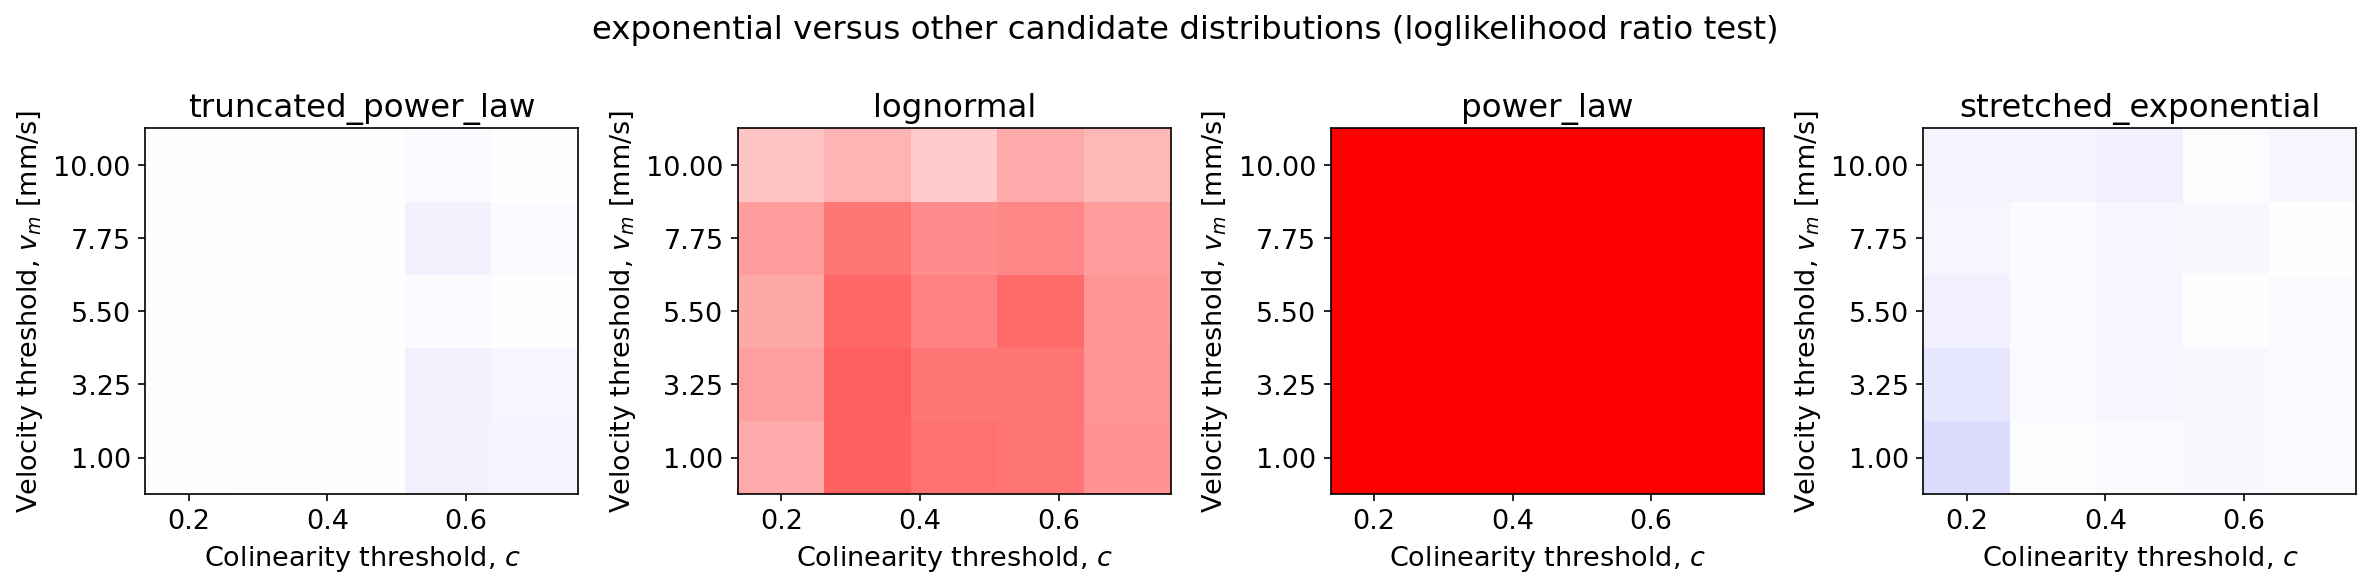

In [80]:
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

norm = mpl.colors.PowerNorm(1, vmin=-10, vmax=10)
fig, ax = plt.subplots(1, len(alternativeDistributions), figsize=(len(alternativeDistributions)*4, 4))

for i in range(len(alternativeDistributions)):

    paramMatrix = comparisonMatrix[:,i,0].reshape((len(uniqueCArr), len(uniqueVArr)))
    ax[i].pcolor(uniqueCArr, uniqueVArr, paramMatrix, cmap='bwr', norm=norm)
    #plt.xticks(uniqueCArr)
    ax[i].set_yticks(uniqueVArr)
    ax[i].set_xlabel('Colinearity threshold, $c$')
    ax[i].set_ylabel('Velocity threshold, $v_m$ [mm/s]')
    ax[i].set_title(f'{alternativeDistributions[i]}')

fig.suptitle(f'{chosenDistribution} versus other candidate distributions (loglikelihood ratio test)')
fig.tight_layout()
plt.show()

## Average speed per run

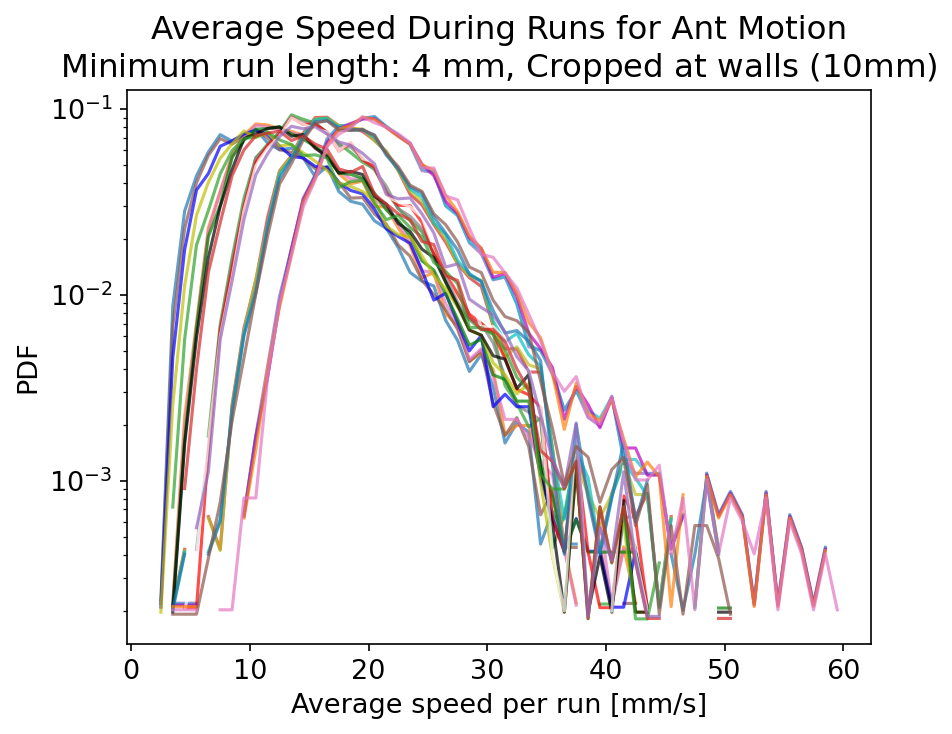

In [83]:
numBins = 50
maxVelocity = 60
minRunLength = minDistancePerRun

fig, ax = plt.subplots()

bins = np.linspace(0, maxVelocity, numBins+1)
#bins = np.logspace(-1, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(discreteDataArr)):
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where((runLengths > minRunLength) & (runTimes > 0))[0]
    avgVelocity = runLengths[goodIndices] / runTimes[goodIndices]

    powerlaw.plot_pdf(avgVelocity, xmax=maxVelocity, linear_bins=True, ax=ax, color=colors[i % len(colors)], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.3}$', alpha=0.7)

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Average speed per run [mm/s]')
#plt.legend(fontsize=10)
#plt.title(f'Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Uncropped')
plt.title(f'Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
pltsaveall('12_AverageSpeedPerRun_Cropped')
plt.show()

/tmp/ipykernel_5644/2851661206.py:10: RuntimeWarning: divide by zero encountered in divide
  avgVelocity = runLengths / runTimes


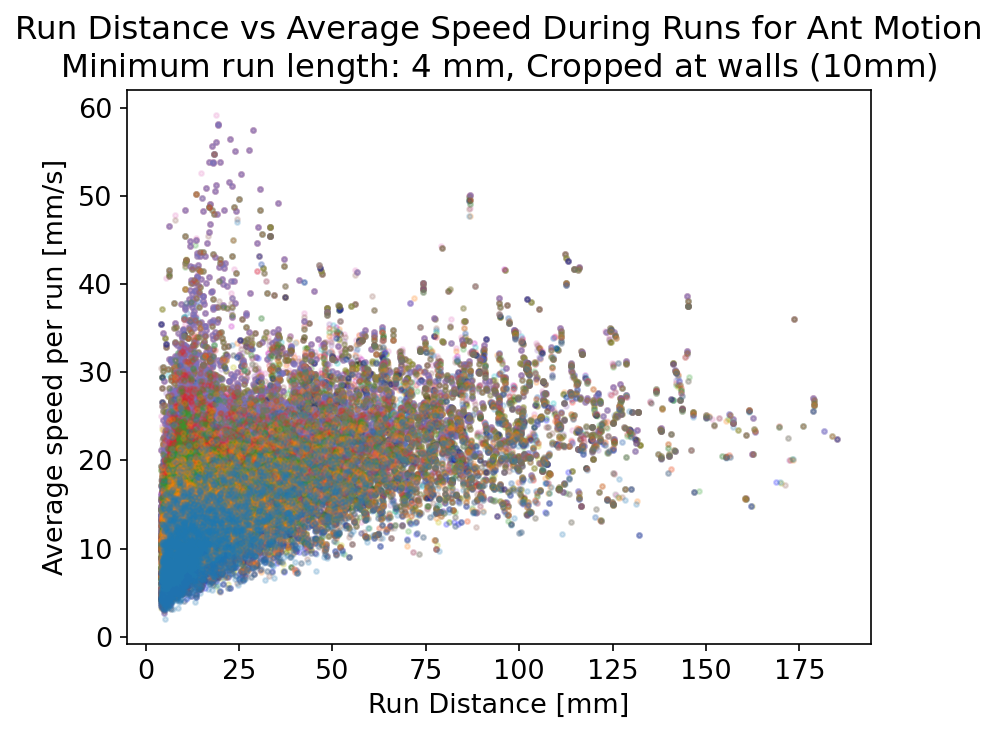

In [91]:
minRunLength = minDistancePerRun
maxSpeed = 60
colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

for i in range(len(runTimeArr))[::-1]:
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where(runLengths > minRunLength)[0]
    avgVelocity = runLengths / runTimes
    
    runLengths = runLengths[goodIndices]
    avgVelocity = avgVelocity[goodIndices]
    
    goodIndices = np.where(avgVelocity <= maxSpeed)[0]

    plt.scatter(runLengths[goodIndices], avgVelocity[goodIndices], alpha=0.2, s=5, c=colors[i % len(colors)])
    # To make the legend look nicer
    plt.scatter(None, None, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i % len(colors)])
    
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Run Distance [mm]')
plt.ylabel('Average speed per run [mm/s]')
#plt.title(f'Skip factor: {skipFactor}')
#plt.legend(fontsize=10)
#plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Uncropped')
plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
#pltsaveall('08_RunDistanceVsSpeed_Cropped')
plt.show()

/tmp/ipykernel_5644/1421173114.py:10: RuntimeWarning: divide by zero encountered in divide
  avgVelocity = runLengths / runTimes


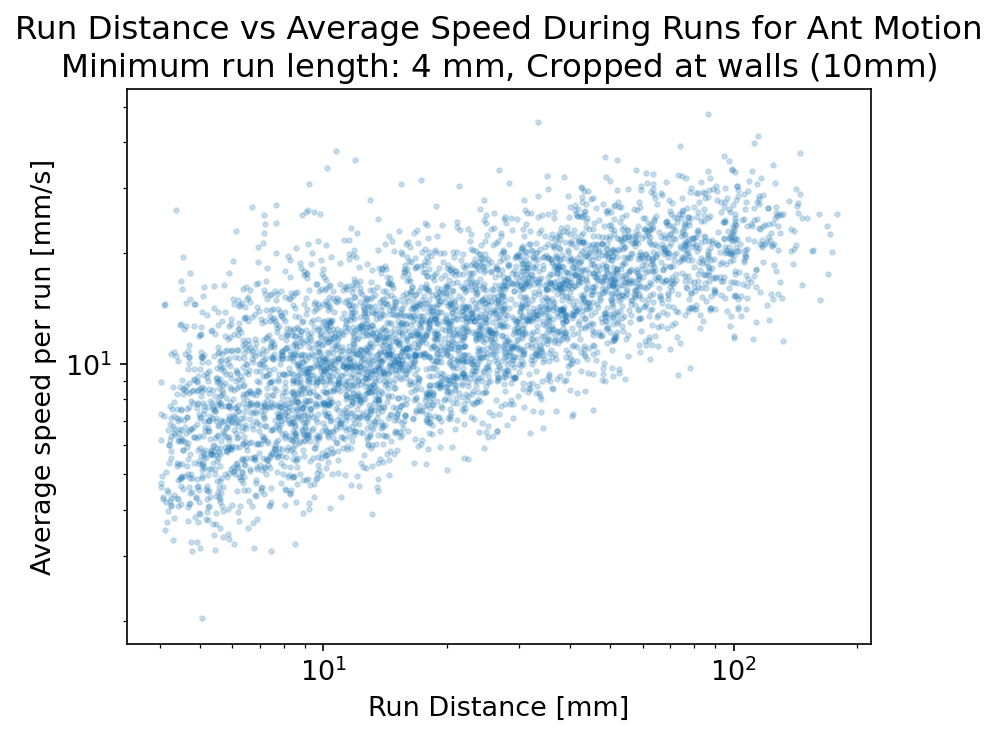

In [98]:
minRunLength = minDistancePerRun
maxSpeed = 60
colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

for i in [0]:
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where(runLengths > minRunLength)[0]
    avgVelocity = runLengths / runTimes
    
    runLengths = runLengths[goodIndices]
    avgVelocity = avgVelocity[goodIndices]
    
    goodIndices = np.where(avgVelocity <= maxSpeed)[0]

    plt.scatter(runLengths[goodIndices], avgVelocity[goodIndices], alpha=0.2, s=5, c=colors[i % len(colors)])
    # To make the legend look nicer
    plt.scatter(None, None, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i % len(colors)])
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Run Distance [mm]')
plt.ylabel('Average speed per run [mm/s]')
#plt.legend(fontsize=10)
plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
#pltsaveall('08_RunDistanceVsSpeed_Cropped')
plt.show()

/tmp/ipykernel_5644/2186631268.py:10: RuntimeWarning: divide by zero encountered in divide
  avgVelocity = runLengths / runTimes


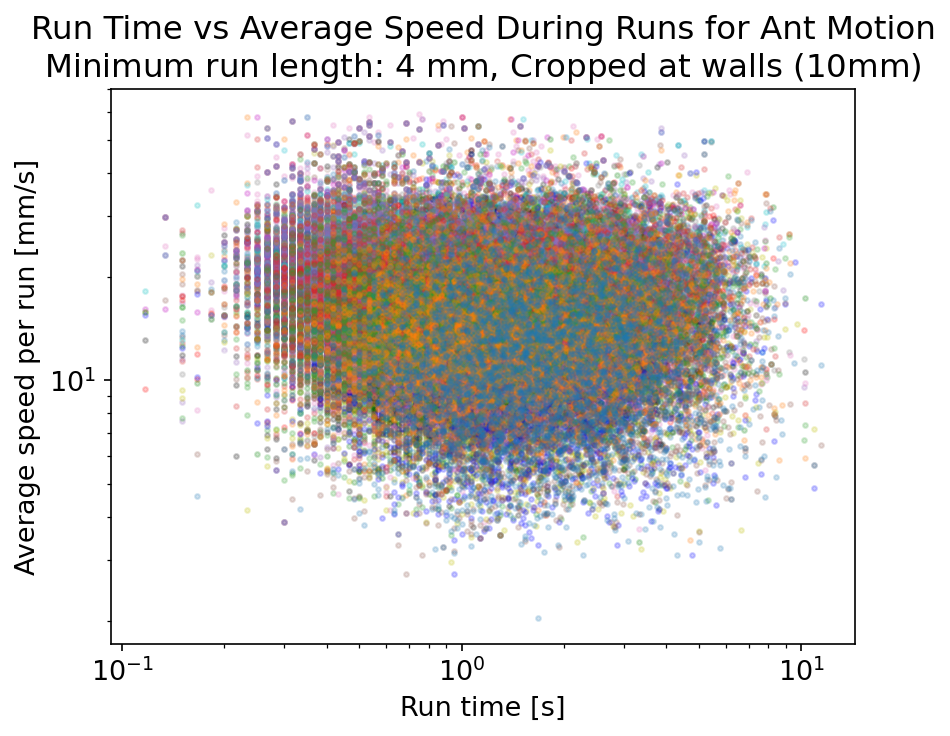

In [100]:
minRunLength = minDistancePerRun
maxSpeed = 60
colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

for i in range(len(runTimeArr))[::-1]:
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where(runLengths > minRunLength)[0]
    avgVelocity = runLengths / runTimes
    
    runLengths = runLengths[goodIndices]
    avgVelocity = avgVelocity[goodIndices]
    
    goodIndices = np.where(avgVelocity <= maxSpeed)[0]

    plt.scatter(runTimes[goodIndices], avgVelocity[goodIndices], alpha=0.2, s=5, c=colors[i % len(colors)])
    # To make the legend look nicer
    plt.scatter(None, None, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i % len(colors)])
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Run time [s]')
plt.ylabel('Average speed per run [mm/s]')
#plt.title(f'Skip factor: {skipFactor}')
#plt.legend(fontsize=10)
#plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Uncropped')
plt.title(f'Run Time vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
#pltsaveall('08_RunDistanceVsSpeed_Cropped')
plt.show()

/tmp/ipykernel_5644/2518872155.py:10: RuntimeWarning: divide by zero encountered in divide
  avgVelocity = runLengths / runTimes


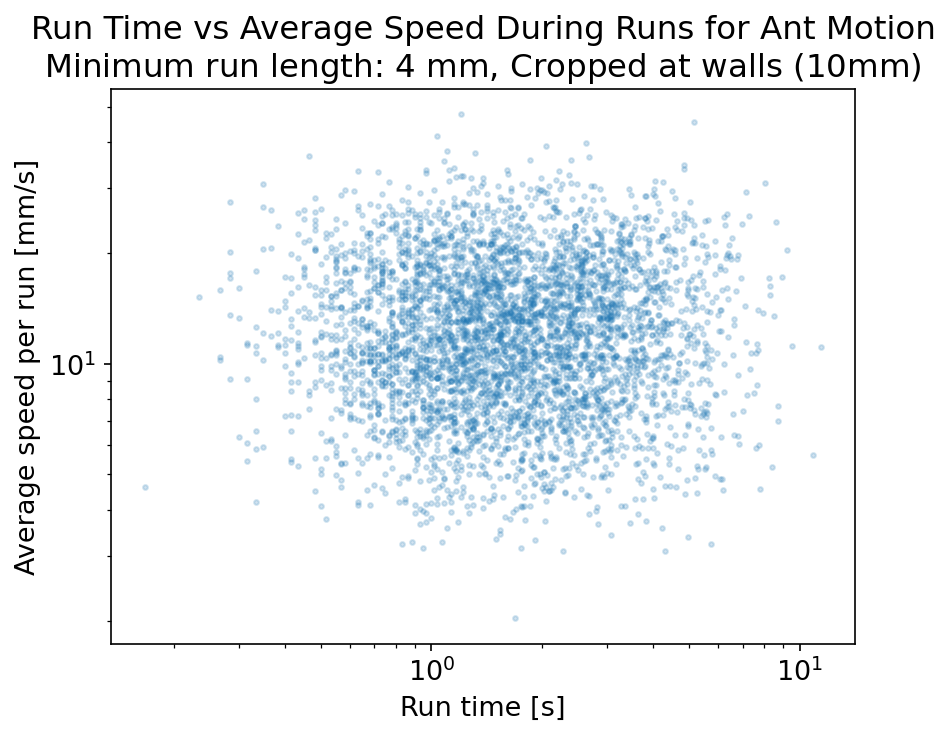

In [103]:
minRunLength = minDistancePerRun
maxSpeed = 60
colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

for i in [0]:
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where(runLengths > minRunLength)[0]
    avgVelocity = runLengths / runTimes
    
    runLengths = runLengths[goodIndices]
    avgVelocity = avgVelocity[goodIndices]
    
    goodIndices = np.where(avgVelocity <= maxSpeed)[0]

    plt.scatter(runTimes[goodIndices], avgVelocity[goodIndices], alpha=0.2, s=5, c=colors[i % len(colors)])
    # To make the legend look nicer
    plt.scatter(None, None, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i % len(colors)])
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Run time [s]')
plt.ylabel('Average speed per run [mm/s]')
#plt.title(f'Skip factor: {skipFactor}')
#plt.legend(fontsize=10)
#plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Uncropped')
plt.title(f'Run Time vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
#pltsaveall('08_RunDistanceVsSpeed_Cropped')
plt.show()